## POS tagging using modified Viterbi

**Problem Statement**

In this assignment, we need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques. Though there could be multiple ways to solve this problem, we may use the following hints:

* Which tag class do you think most unknown words belong to? Can you identify rules (e.g. based on morphological cues) that can be used to tag unknown words? You may define separate python functions to exploit these rules so that they work in tandem with the original Viterbi algorithm.

* Why does the Viterbi algorithm choose a random tag on encountering an unknown word? Can you modify the Viterbi algorithm so that it considers only one of the transition or emission probabilities for unknown words?



**Sample Test Sentences**

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satellite.




### Data Preparation

In [1]:
#Importing libraries
import nltk

For this assignment, we'll use the Treebank dataset of NLTK with the 'universal' tagset. The Universal tagset of NLTK comprises only 12 coarse tag classes as follows: Verb, Noun, Pronouns, Adjectives, Adverbs, Adpositions, Conjunctions, Determiners, Cardinal Numbers, Particles, Other/ Foreign words, Punctuations.

In [2]:
# reading the Treebank tagged sentences
nltk.download('universal_tagset')
nltk.download('treebank')
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


In [3]:
print(nltk_data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
print("Total nltk sentences = {}".format(len(nltk_data)))

Total nltk sentences = 3914


You can split the Treebank dataset into train and validation sets. Please use a sample size of 95:5 for training: validation sets, i.e. keep the validation size small, else the algorithm will need a very high amount of runtime.


In [5]:
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.95
TEST_SIZE = 1 - TRAIN_SIZE
train_set, test_set = train_test_split(nltk_data,train_size=TRAIN_SIZE, test_size=TEST_SIZE)

In [6]:
print("Train sentences len {trl} Test set len {tel}".format(trl=len(train_set),tel=len(test_set)))

Train sentences len 3718 Test set len 196


In [7]:
train_tag_words = [t for s in train_set for t in s]
print((train_tag_words[0:10]))

[('Too', 'ADV'), ('much', 'ADJ'), ('money', 'NOUN'), ('*ICH*-1', 'X'), ('is', 'VERB'), ('at', 'ADP'), ('stake', 'NOUN'), ('for', 'ADP'), ('program', 'NOUN'), ('traders', 'NOUN')]


In [8]:
test_tag_words = [t for s in test_set for t in s]
print((test_tag_words[0:10]))

[('Many', 'ADJ'), ('felt', 'VERB'), ('0', 'X'), ('Hearst', 'NOUN'), ('kept', 'VERB'), ('the', 'DET'), ('paper', 'NOUN'), ('alive', 'ADJ'), ('as', 'ADP'), ('long', 'ADV')]


In [9]:
print("Train train_tag_words len {trl} test_tag_words len {tel}".format(trl=len(train_tag_words),tel=len(test_tag_words)))

Train train_tag_words len 95598 test_tag_words len 5078


In [10]:
train_tagged_tokens = [t[0] for t in train_tag_words]
print(train_tagged_tokens[:10])

['Too', 'much', 'money', '*ICH*-1', 'is', 'at', 'stake', 'for', 'program', 'traders']


In [11]:
train_tagged_pos_tokens = sorted(list(set([t[1] for t in train_tag_words])))
print(train_tagged_pos_tokens[:10])

['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT']


In [12]:
training_vocabulary_set = set(train_tagged_tokens)

In [13]:
import numpy as np
#Emission probability 
transition = len(train_tagged_pos_tokens)
emission = len(training_vocabulary_set)
wt = np.zeros((transition, emission))

In [14]:
#Emission Calculate

def emf(word, tag, bag=train_tag_words):
    tag_found = [pair for pair in bag if pair[1] == tag]
    No_t_appears = len(tag_found)
    w_given_tag_list = [pair[0] for pair in tag_found if pair[0]==word]
    count_word_given_tag = len(w_given_tag_list)
    
    return (count_word_given_tag,No_t_appears )
        

In [15]:
print(emf('acquisition','NOUN',bag=train_tag_words))

(13, 27366)


In [16]:
def transition(t2, t1, bag=train_tag_words):
    #P(t2|t1)= (No.of times t1 is followed by tag t2)/(No.of times t1 appears)

    tags = [p[1] for p in bag]
    t1_num = len([t for t in tags if t==t1])
    
    no_of_times_t1_followed_by_t2 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            no_of_times_t1_followed_by_t2 += 1
            
    return (no_of_times_t1_followed_by_t2, t1_num)

In [17]:
print(transition('ADJ', 'NOUN',bag=train_tag_words))

(324, 27366)


In [18]:
tagsmatrix = np.zeros((len(train_tagged_pos_tokens), len(train_tagged_pos_tokens)), dtype='float32')
for i, t1 in enumerate(list(train_tagged_pos_tokens)):
    for j, t2 in enumerate(list(train_tagged_pos_tokens)): 
      print(t1,t2)
      tagsmatrix[i, j] = transition(t2, t1,bag=train_tag_words)[0]/transition(t2, t1,bag=train_tag_words)[1]

. .
. ADJ
. ADP
. ADV
. CONJ
. DET
. NOUN
. NUM
. PRON
. PRT
. VERB
. X
ADJ .
ADJ ADJ
ADJ ADP
ADJ ADV
ADJ CONJ
ADJ DET
ADJ NOUN
ADJ NUM
ADJ PRON
ADJ PRT
ADJ VERB
ADJ X
ADP .
ADP ADJ
ADP ADP
ADP ADV
ADP CONJ
ADP DET
ADP NOUN
ADP NUM
ADP PRON
ADP PRT
ADP VERB
ADP X
ADV .
ADV ADJ
ADV ADP
ADV ADV
ADV CONJ
ADV DET
ADV NOUN
ADV NUM
ADV PRON
ADV PRT
ADV VERB
ADV X
CONJ .
CONJ ADJ
CONJ ADP
CONJ ADV
CONJ CONJ
CONJ DET
CONJ NOUN
CONJ NUM
CONJ PRON
CONJ PRT
CONJ VERB
CONJ X
DET .
DET ADJ
DET ADP
DET ADV
DET CONJ
DET DET
DET NOUN
DET NUM
DET PRON
DET PRT
DET VERB
DET X
NOUN .
NOUN ADJ
NOUN ADP
NOUN ADV
NOUN CONJ
NOUN DET
NOUN NOUN
NOUN NUM
NOUN PRON
NOUN PRT
NOUN VERB
NOUN X
NUM .
NUM ADJ
NUM ADP
NUM ADV
NUM CONJ
NUM DET
NUM NOUN
NUM NUM
NUM PRON
NUM PRT
NUM VERB
NUM X
PRON .
PRON ADJ
PRON ADP
PRON ADV
PRON CONJ
PRON DET
PRON NOUN
PRON NUM
PRON PRON
PRON PRT
PRON VERB
PRON X
PRT .
PRT ADJ
PRT ADP
PRT ADV
PRT CONJ
PRT DET
PRT NOUN
PRT NUM
PRT PRON
PRT PRT
PRT VERB
PRT X
VERB .
VERB ADJ
VERB ADP
VER

In [19]:
import pandas as pd
tags_dataframe = pd.DataFrame(tagsmatrix, columns = list(train_tagged_pos_tokens), index=list(train_tagged_pos_tokens))

In [20]:
tags_dataframe.head(11)

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,0.092977,0.044518,0.091455,0.052042,0.058581,0.172608,0.222501,0.081691,0.065120,0.002150,0.089305,0.026962
ADJ,0.065681,0.066831,0.077504,0.004926,0.016913,0.004762,0.698851,0.020854,0.000657,0.010509,0.011330,0.021182
ADP,0.039996,0.107838,0.017095,0.012902,0.000753,0.324159,0.319966,0.063004,0.069025,0.001505,0.008494,0.035265
ADV,0.134839,0.130189,0.117901,0.079044,0.007307,0.068748,0.032215,0.031219,0.015277,0.013617,0.346064,0.023580
CONJ,0.036490,0.116859,0.051732,0.054965,0.000462,0.117321,0.350577,0.041570,0.058661,0.004619,0.157968,0.008776
DET,0.017773,0.206021,0.009672,0.012937,0.000242,0.005683,0.636441,0.021642,0.003506,0.000121,0.040019,0.045944
NOUN,0.241541,0.011840,0.175144,0.017102,0.042936,0.013338,0.263868,0.009464,0.004604,0.043704,0.147080,0.029380
NUM,0.115021,0.032821,0.034004,0.002661,0.012714,0.003548,0.357776,0.183323,0.001478,0.027794,0.017445,0.211413
PRON,0.041186,0.072748,0.023095,0.035027,0.004619,0.009238,0.210547,0.006543,0.007698,0.012317,0.485758,0.091224
PRT,0.043250,0.083552,0.019332,0.009502,0.002294,0.101573,0.245085,0.058650,0.019004,0.001966,0.402359,0.013434


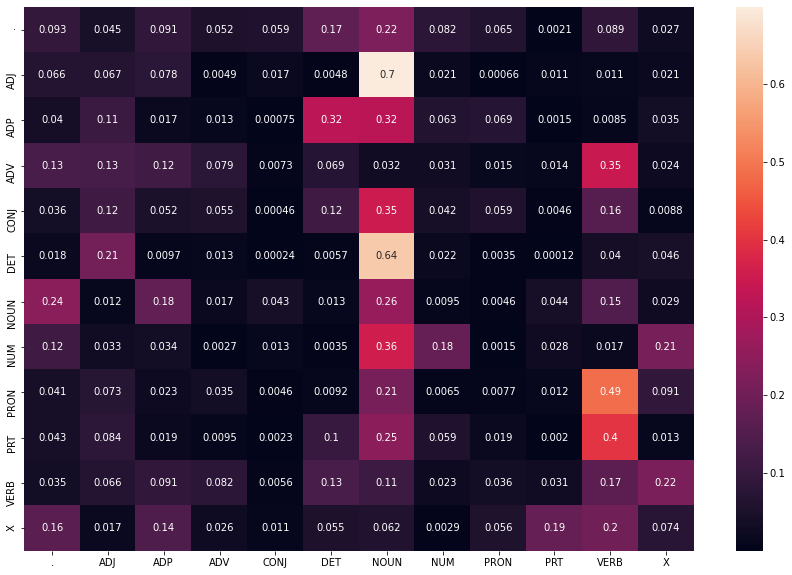

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,10))
sns.heatmap(tags_dataframe, annot=True)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [22]:
#The Viterbi algorithm is a dynamic programming algorithm for obtaining the maximum a 
#posteriori probability estimate of the most likely sequence of hidden states—called 
#the Viterbi path—that results in a sequence of observed events, especially in the 
#context of Markov information sources and hidden Markov models (HMM).

In [23]:
train_tag_words[:10]

[('Too', 'ADV'),
 ('much', 'ADJ'),
 ('money', 'NOUN'),
 ('*ICH*-1', 'X'),
 ('is', 'VERB'),
 ('at', 'ADP'),
 ('stake', 'NOUN'),
 ('for', 'ADP'),
 ('program', 'NOUN'),
 ('traders', 'NOUN')]

#GOAL 1

Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 


In [25]:
def viterbi_heuristic(words, bag):
    states = []
    tags = sorted(list(set([pair[1] for pair in bag])))
    
    for index, word in enumerate(words):
        p = []
        
        for tag in tags:
            if index == 0: 
                transition_p = tags_dataframe.loc['.', tag]                 
            else:
                transition_p = tags_dataframe.loc[states[-1], tag]
                
            if emf(words[index], tag)[1] == 0:
                emission_p = emf(words[index], tag)[0]/(emf(words[index], tag)[1] + 1)
            else:
                emission_p = emf(words[index], tag)[0]/emf(words[index], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        probmax = max(p)
        state_max = tags[p.index(probmax)]
        states.append(state_max)
        
    return list(zip(words, states))
    

In [26]:
import random
# choose 5 random sents
rndom = [random.randint(1, len(test_set)) for x in range(5)]

# list of sents
test_sents = [test_set[i] for i in rndom]

# list of tagged words
test_tagged_words = [tup for sent in test_sents for tup in sent]

# list of untagged words
test_untagged_words = [tup[0] for sent in test_sents for tup in sent]

In [27]:
tagged_seq = viterbi_heuristic(test_untagged_words,bag=train_tag_words)

In [28]:
# accuracy
vanilla_pos = [i for i, j in zip(tagged_seq, test_tagged_words) if i == j] 
vanilla_viterbi_accuracy = len(vanilla_pos)/len(tagged_seq) * 100
print('Vanilla Viterbi Algorithm Accuracy: ', vanilla_viterbi_accuracy)

Vanilla Viterbi Algorithm Accuracy:  92.5925925925926


In [29]:
incorrect_tagged_cases_vanilla_viterbi_accuracy = [j for i, j in enumerate(zip(tagged_seq, test_tagged_words)) if j[0]!=j[1]]

In [30]:
incorrect_tagged_cases_vanilla_viterbi_accuracy

[(('fielded', '.'), ('fielded', 'VERB')),
 (('dominant', '.'), ('dominant', 'ADJ')),
 (('Yasuda', '.'), ('Yasuda', 'NOUN')),
 (('surge', 'NOUN'), ('surge', 'VERB')),
 (('Gasoline', '.'), ('Gasoline', 'NOUN')),
 (('sell-off', '.'), ('sell-off', 'NOUN')),
 (('Risks', '.'), ('Risks', 'NOUN')),
 (('erodes', '.'), ('erodes', 'VERB'))]

####This is due to emission probability 0 as if it hits unknown word it assigns first tag in list of tags
####E(w|t)= (No.of times w has been tagged as t)/(No.of times t appears)


---



#GOAL 2 Strategy: 1

Solve the problem of unknown words using at least two techniques. 

Strategy: 1 Use transition probability when emission is zero

In [31]:
def viterbi_heuristic_1(words, bag):
    states = []
    tags = sorted(list(set([pair[1] for pair in bag])))
    Vocab = [pair[0] for pair in bag]
    
    for index, word in enumerate(words):
        p = []
        
        for tag in tags:
            if index == 0: 
                transition_p = tags_dataframe.loc['.', tag]                 
            else:
                transition_p = tags_dataframe.loc[states[-1], tag]
                
            if emf(words[index], tag)[1] == 0:
                emission_p = emf(words[index], tag)[0]/(emf(words[index], tag)[1] + 1)
            else:
                emission_p = emf(words[index], tag)[0]/emf(words[index], tag)[1]

            if word not in Vocab:
              state_probability = transition_p
            else:
              state_probability = emission_p * transition_p    
              
            p.append(state_probability)
            
        probmax = max(p)
        state_max = tags[p.index(probmax)]
        states.append(state_max)
        
    return list(zip(words, states))
    

In [32]:
tagged_seq = viterbi_heuristic_1(test_untagged_words,bag=train_tag_words)

In [33]:
# accuracy
vanilla_pos = [i for i, j in zip(tagged_seq, test_tagged_words) if i == j] 
viterbi_accuracy_transition_when_emission_zero = len(vanilla_pos)/len(tagged_seq) * 100
print('Viterbi viterbi_accuracy_transition_when_emission_zero Accuracy: ', viterbi_accuracy_transition_when_emission_zero)

Viterbi viterbi_accuracy_transition_when_emission_zero Accuracy:  94.44444444444444


In [34]:
incorrect_tagged_cases_viterbi_accuracy_transition_when_emission_zero = [j for i, j in enumerate(zip(tagged_seq, test_tagged_words)) if j[0]!=j[1]]

In [35]:
incorrect_tagged_cases_viterbi_accuracy_transition_when_emission_zero

[(('fielded', 'NOUN'), ('fielded', 'VERB')),
 (('dominant', 'VERB'), ('dominant', 'ADJ')),
 (('Yasuda', 'X'), ('Yasuda', 'NOUN')),
 (('surge', 'NOUN'), ('surge', 'VERB')),
 (('that', 'ADP'), ('that', 'DET')),
 (('erodes', 'NOUN'), ('erodes', 'VERB'))]

#**Observations :**

1. Accuracy increased from 92.5925925925926 to 94.44444444444444.
2. Words which are correct now:

Gasoline, sell-off, Risks are now correctely predicted.


#GOAL 2 Strategy: 2
Solve the problem of unknown words using at least two techniques. 

Strategy: 2 Use most common tag 

In [42]:
def most_common(lst):
    return max(set(lst), key=lst.count)

In [43]:
most_common(sorted(list(([pair[1] for pair in train_tag_words]))))

'NOUN'

In [44]:
def viterbi_heuristic_2(words, bag):
    states = []
    tags = sorted(list(set([pair[1] for pair in bag])))
    most_common_tag = most_common(tags)
    Vocab = [pair[0] for pair in bag]
    
    for index, word in enumerate(words):
        p = []

       
        for tag in tags:
            if index == 0: 
                transition_p = tags_dataframe.loc['.', tag]                 
            else:
                transition_p = tags_dataframe.loc[states[-1], tag]
                
            if emf(words[index], tag)[1] == 0:
                emission_p = emf(words[index], tag)[0]/(emf(words[index], tag)[1] + 1)
            else:
                emission_p = emf(words[index], tag)[0]/emf(words[index], tag)[1]

            
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        if pmax == 0:
          state_max = 'NOUN'
        else :
          state_max = tags[p.index(pmax)]
        states.append(state_max)
        
    return list(zip(words, states))
    

In [45]:
tagged_seq = viterbi_heuristic_2(test_untagged_words,bag=train_tag_words)

In [46]:
# accuracy
vanilla_pos = [i for i, j in zip(tagged_seq, test_tagged_words) if i == j] 
viterbi_accuracy_most_common = len(vanilla_pos)/len(tagged_seq) * 100
print('viterbi_accuracy_most_common Accuracy: ', viterbi_accuracy_most_common)

viterbi_accuracy_most_common Accuracy:  95.37037037037037


In [47]:
incorrect_tagged_cases_viterbi_accuracy_most_common = [j for i, j in enumerate(zip(tagged_seq, test_tagged_words)) if j[0]!=j[1]]
incorrect_tagged_cases_viterbi_accuracy_most_common

[(('fielded', 'NOUN'), ('fielded', 'VERB')),
 (('dominant', 'NOUN'), ('dominant', 'ADJ')),
 (('surge', 'NOUN'), ('surge', 'VERB')),
 (('that', 'ADP'), ('that', 'DET')),
 (('erodes', 'NOUN'), ('erodes', 'VERB'))]

#**Observations :**

1. Accuracy increased from 94.44444444444444 to 95.37037037037037.
2. Words which are correct now:

Yasuda is now correctely predicted.



#GOAL 2 Strategy: 3
Solve the problem of unknown words using at least two techniques. 

Strategy: 3 Using Rule Base

In [48]:
def viterbi_heuristic_3(words, bag):
    states = []
    tags = sorted(list(set([pair[1] for pair in bag])))
    most_common_tag = most_common(tags)
    Vocab = [pair[0] for pair in bag]
    
    for index, word in enumerate(words):
        p = []

        if word not in Vocab:
              tag = 'NOUN'
              if word.endswith('ous'):
                tag = 'ADJ'
              elif word.endswith('ly'):
                tag = 'ADJ'
              elif word.endswith('ould'):
                tag = 'X'
              elif word.endswith(('The','the','A','a','An','an')):
                tag = 'DET'
              elif word.endswith('able'):
                tag = 'ADJ'
              elif word.endswith('ing'):
                tag = 'VERB'
              elif word[-1].isdigit():
                tag = 'NUM'
              elif word.endswith('ed'):
                tag = 'VERB'
              elif word.endswith('es'):
                tag = 'VERB'
              elif word.endswith('s'):
                tag = 'NOUN'
              states.append(tag)
        
        else:
          for tag in tags:
              if index == 0: 
                  transition_p = tags_dataframe.loc['.', tag]                 
              else:
                  transition_p = tags_dataframe.loc[states[-1], tag]
                  
              if emf(words[index], tag)[1] == 0:
                  emission_p = emf(words[index], tag)[0]/(emf(words[index], tag)[1] + 1)
              else:
                  emission_p = emf(words[index], tag)[0]/emf(words[index], tag)[1]

      
              state_probability = emission_p * transition_p    
                
              p.append(state_probability)
              
          probmax = max(p)
          state_max = tags[p.index(probmax)]
          states.append(state_max)
        
    return list(zip(words, states))
    

In [49]:
tagged_seq = viterbi_heuristic_3(test_untagged_words,bag=train_tag_words)
# accuracy
vanilla_pos = [i for i, j in zip(tagged_seq, test_tagged_words) if i == j] 
viterbi_accuracy_rule_based = len(vanilla_pos)/len(tagged_seq) * 100
print('viterbi_accuracy_rule_based Algorithm 3 Accuracy: ', viterbi_accuracy_rule_based)

viterbi_accuracy_rule_based Algorithm 3 Accuracy:  96.29629629629629


In [50]:
incorrect_tagged_cases_viterbi_accuracy_rule_based = [j for i, j in enumerate(zip(tagged_seq, test_tagged_words)) if j[0]!=j[1]]

In [51]:
incorrect_tagged_cases_viterbi_accuracy_rule_based

[(('dominant', 'NOUN'), ('dominant', 'ADJ')),
 (('Yasuda', 'DET'), ('Yasuda', 'NOUN')),
 (('surge', 'NOUN'), ('surge', 'VERB')),
 (('that', 'ADP'), ('that', 'DET'))]

#**Observations :**

1. Accuracy increased from 95.37037037037037 to 96.29629629629629 .
2. Words which are correct now:

fielded, erodes is now correctely predicted.


#GOAL 3

Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.

In [60]:
acc_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy], 
                  ['Viterbi accuracy transition_when_emission_zero', viterbi_accuracy_transition_when_emission_zero], 
                  ['Viterbi accuracy most_common', viterbi_accuracy_most_common ],
                  ['Viterbi accuracy rule_based', viterbi_accuracy_rule_based ],]

acc_data_df = pd.DataFrame(acc_data, columns = ['Algorithm', 'Accuracy'])
acc_data_df.set_index('Algorithm', drop = True, inplace = True)
acc_data_df

,Accuracy
Algorithm,
Vanilla Viterbi,92.592593
Viterbi accuracy transition_when_emission_zero,94.444444
Viterbi accuracy most_common,95.370370
Viterbi accuracy rule_based,96.296296


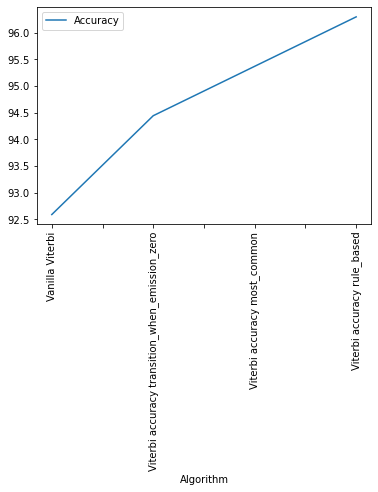

In [62]:
acc_data_df.plot.line(rot = 90, legend = True)

#GOAL 4

Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [ ]:
List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.


In [63]:
from nltk.tokenize import word_tokenize


In [69]:
nltk.download('punkt')
sentense_test_1 = "Android is a mobile operating system developed by Google."
words = word_tokenize(sentense_test_1)
tagged_seq = viterbi_heuristic(words,bag=train_tag_words)
print(tagged_seq)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[('Android', '.'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', '.'), ('.', '.')]


In [71]:
tagged_seq = viterbi_heuristic_3(words,bag=train_tag_words)
print(tagged_seq)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]




1.   'Android' is properly tagged with 'NOUN' in modified Viterbi Algorithm.
2. 'Google' is properly tagged with 'NOUN' in modified Viterbi Algorithm.


In [72]:
sentense_test_1 = "Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013."
words = word_tokenize(sentense_test_1)
tagged_seq = viterbi_heuristic(words,bag=train_tag_words)
print(tagged_seq)

[('Android', '.'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', '.'), ('worldwide', '.'), ('on', 'ADP'), ('smartphones', '.'), ('since', 'ADP'), ('2011', '.'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', '.'), ('.', '.')]


In [73]:
tagged_seq = viterbi_heuristic_3(words,bag=train_tag_words)
print(tagged_seq)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


1. 'Android' is properly tagged with 'NOUN' in modified Viterbi Algorithm.
2. 'OS' is properly tagged with 'NOUN' in modified Viterbi Algorithm.
3. 'worldwide' is properly tagged with 'NOUN' in modified Viterbi Algorithm.
4. 'smartphones' is properly tagged with 'VERB' in modified Viterbi Algorithm.
5. '2011' is properly tagged with 'NUM' in modified Viterbi Algorithm.
6. '2013' is properly tagged with 'NUM' in modified Viterbi Algorithm.




In [74]:
sentense_test_1 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
words = word_tokenize(sentense_test_1)
tagged_seq = viterbi_heuristic(words,bag=train_tag_words)
print(tagged_seq)

[('Google', '.'), ('and', 'CONJ'), ('Twitter', '.'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', '.'), ('that', 'DET'), ('gave', 'VERB'), ('Google', '.'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', '.'), ("'s", 'VERB'), ('firehose', '.'), ('.', '.')]


In [75]:
tagged_seq = viterbi_heuristic_3(words,bag=train_tag_words)
print(tagged_seq)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


1. 'Google' is properly tagged with 'NOUN' in modified Viterbi Algorithm.
2. 'Twitter' is properly tagged with 'NOUN' in modified Viterbi Algorithm.
3. '2015' is properly tagged with 'NUM' in modified Viterbi Algorithm.
4. 'that' is properly tagged with 'ADP' in modified Viterbi Algorithm.
5. 'firehose' is properly tagged with 'NOUN' in modified Viterbi Algorithm.

